# Packages

Below are the packages required for this assignment, feel free to import more if needed.

In [1]:
import time
import zarr
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt
from scipy import ndimage
import SimpleITK as sitk
%matplotlib inline

# 1 - Data inspection / preprocessing

## 1.1 - Load the sample data
You are given a sample CT volume and its annotation for several heart structures in the data folder:
- `sample_CT_volume.zarr.zip` contains the CT volume and the xy spacing / z spacing of this scan
- `sample_annotation.zarr.zip` contains the annotation mask and the label information
- This CT volume is of shape (256, 512, 512) corresponding to axes (z, y, x)
- The annotation is a multi-class mask where each voxel value indicates the annotated label

Load the data by running the code below.

In [2]:
# load the data
with zarr.open('./data/sample_CT_volume.zarr.zip', mode='r') as z:
    ct_volume = z['image'][:]
    xy_spacing = z.attrs['xy_spacing']
    z_spacing = z.attrs['z_spacing']
    
with zarr.open('./data/sample_annotation.zarr.zip', mode='r') as z:
    mask = z['mask'][:]
    classes = z.attrs['classes']

In [3]:
# explore the data
print(f'CT volume dimension: {ct_volume.shape}')
print(f'CT xy spacing: {xy_spacing}mm')
print(f'CT z spacing: {z_spacing}mm')
print('Labels:', classes)

CT volume dimension: (256, 512, 512)
CT xy spacing: 0.398438mm
CT z spacing: 0.625mm
Labels: {'0': 'background', '1': 'left ventricular volume', '2': 'left ventricular wall', '3': 'right ventricular volume', '4': 'right atrial volume', '5': 'left atrial volume'}


<img src='./vis/image_and_annotation.png'>
<caption><center>One sample slice and its annotation in the axial view</center></caption>

## 1.2 - Image resizing
Since the CT scan usually comes in anisotropic dimension with different spacings, it's sometimes required to resize them into isotropic volume for further steps. 
- The first task you are asked to do is to resize the given CT volume into an isotropic one with 1mm spacing
- Resize the annotation mask as well into an isotropic volume with 1mm spacing
- Please complete the functions in the cell below, you can call any function from any librarie and feel free to add helper functions as you see fit
- Run and time the functions to resize the volumes

CT resample timing 403.5 ms.
Annotation resample timing 109.9 ms.


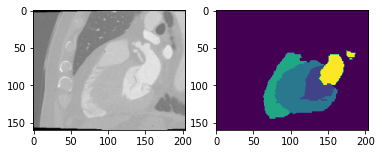

In [4]:
# RESIZING FUNCTIONS
# We implemented two resampling methods. One using Simple ITK, the other using scipy ndimage.
# It looks like ndimage is faster.

# resmaple using simple itk
# only orders 0,1 are currently supported
def resize_sitk(image,xy_spacing,z_spacing,out_xy_spacing=1,out_z_spacing=1,order=1):
    image_sitk = sitk.GetImageFromArray(image)   # Convert to ITK object
    orig_spacing=[xy_spacing,xy_spacing,z_spacing]
    image_sitk.SetSpacing(orig_spacing)
    resample = sitk.ResampleImageFilter()
    resample.SetTransform(sitk.Transform())
    if order == 0:
        resample.SetInterpolator = sitk.sitkNearestNeighbor
    if order == 1:
        resample.SetInterpolator = sitk.sitkLinear
    
    
    resample.SetOutputDirection = image_sitk.GetDirection()
    resample.SetOutputOrigin = image_sitk.GetOrigin()
    resample.SetDefaultPixelValue(image_sitk.GetPixelIDValue())
    new_spacing = [out_xy_spacing, out_xy_spacing,out_z_spacing]
    resample.SetOutputSpacing(new_spacing)
    orig_size = image.shape[::-1]
    new_size = orig_size*(np.array(orig_spacing)/np.array(new_spacing))
    new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
    new_size = [int(s) for s in new_size]
    resample.SetSize(new_size)
    new_image_sitk = resample.Execute(image_sitk)
    new_image = sitk.GetArrayFromImage(new_image_sitk)  # Convert to numpy
    return new_image

#resmaple using ndimage
def resize_ndimage(image,xy_spacing,z_spacing,out_xy_spacing=1,out_z_spacing=1,order=1):
    zoom_xy = xy_spacing/out_xy_spacing
    zoom_z = z_spacing/out_z_spacing
    zoom_factor = (zoom_z,zoom_xy,zoom_xy)
    new_volume = ndimage.zoom(image,zoom_factor,order=order)
    
    return new_volume

def resize_ct_volume(ct_volume, xy_spacing, z_spacing, out_xy_spacing=1, out_z_spacing=1):
    """
    Arguments:
    ct_volume -- the 3D image of a CT scan
    xy_spacing -- original xy spacing of the scan
    z_spacing -- original z spacing of the scan
    out_xy_spacing -- xy spacing of the target volume
    out_z_spacing -- z spacing of the target volume
    
    Returns:
    new_volume -- the target volume 
    """
    
    # YOUR CODE HERE
    new_volume = resize_ndimage(ct_volume,xy_spacing,z_spacing,out_xy_spacing=1,out_z_spacing=1,order=1)
    
    # alternative resizing using simple itk - but this looks slower
    #new_volume = resize_sitk(ct_volume,xy_spacing,z_spacing,out_xy_spacing,out_z_spacing=1,order=1)
    
    return new_volume


def resize_annotation(mask, xy_spacing, z_spacing, out_xy_spacing=1, out_z_spacing=1):
    """
    Arguments:
    mask -- the 3D multi-class annotation mask of a CT scan
    xy_spacing -- original xy spacing of the mask
    z_spacing -- original z spacing of the mask
    out_xy_spacing -- xy spacing of the target mask
    out_z_spacing -- z spacing of the target mask
    
    Returns:
    new_mask -- the target mask
    """
    
    # YOUR CODE HERE
    
    new_mask = resize_ndimage(mask,xy_spacing,z_spacing,out_xy_spacing=1,out_z_spacing=1,order=0)
    
    # alternative resizing using simple itk - but this looks slower
    #new_volume = resize_sitk(ct_volume,xy_spacing,z_spacing,out_xy_spacing,out_z_spacing=1,order=0)
        
    return new_mask

# Average timings over several repeats 
nrepeat = 10
dt_ct = 0
dt_annotation = 0

out_xy_spacing =1
out_z_spacing = 1
for _ in range(nrepeat):
    t0=time.time()
    new_volume = resize_ct_volume(ct_volume, xy_spacing, z_spacing,
                                  out_xy_spacing = out_xy_spacing,
                                  out_z_spacing = out_z_spacing)
    t1=time.time()
    new_mask = resize_annotation(mask, xy_spacing, z_spacing, 
                                 out_xy_spacing = out_xy_spacing,
                                 out_z_spacing = out_z_spacing)
    t2=time.time()
    dt_ct += t1-t0
    dt_annotation += t2-t1
dt_ct = dt_ct/nrepeat
dt_annotation = dt_annotation/nrepeat
    
print(f'CT resample timing {1000*dt_ct:4.1f} ms.')
print(f'Annotation resample timing {1000*dt_annotation:4.1f} ms.')

    
fig, axs = plt.subplots(1,2)
axs[0].imshow(new_volume[:,:,102],cmap='gray')
axs[1].imshow(new_mask[:,:,102])


<img src='./vis/original_vs_isotropic.png'>
<caption><center>The original image and the resized result of one sample slice in the sagittal view</center></caption>

## 1.3 - 3D visualization
Now you have the resized ct volume and the annotation mask, could you come up with any way(s) to inspect the data in 3D?
- Run the cell below to see an example generated with Plotly in which the contour points on each slice are plotted for each annotated structure
- Note that since the origin lies at the bottom in this visualization, the mask has been reversed in z axis so that the heart doesn't look upside down
- You can either visualize the ct volume or the annotation mask, or both. You can also replicate the example provided

In [5]:
IFrame(src='./vis/3D_vis.html', width=700, height=600)

In [76]:
# YOUR VIS CODE AND OUTPUT HERE
level = 100 # isosurface level to visualize
from plotly.figure_factory import create_trisurf
import numpy as np
from skimage import measure
import plotly.graph_objects as go
out_spacing=[out_z_spacing,out_xy_spacing,out_xy_spacing]
colormap = ['rgb(128,128,245)','rgb(128,128,255)']
backgroundcolor='rgb(128,128,128)'
verts,faces,_,_ = measure.marching_cubes(new_volume[::-1,:,:],level = level,spacing=out_spacing,step_size=1)
z, y, x = verts.T
i, j, k = faces.T

#fig=create_trisurf(z=verts[:,0],y=verts[:,1],x=verts[:,2],colormap=colormap,
#                   backgroundcolor=backgroundcolor,simplices=faces,title='Cardiac CT')


fig = go.Figure()
fig.add_trace(go.Mesh3d(x=x, y=y, z=z, i=i,j=j,k=k,color='grey', opacity=0.50, 
                        name='CT volume',showlegend=True))


colors=['lightblue','red','lightgreen','magenta','orange']
for label in range(1,6):
    label_verts,label_faces,_,_ = measure.marching_cubes(new_mask[::-1,:,:]==label,level = 0.999,spacing=out_spacing,step_size=1)
    z, y, x = label_verts.T
    i, j, k = label_faces.T
    name = classes[str(label)]
    
    fig.add_trace(go.Mesh3d(x=x, y=y, z=z, i=i,j=j,k=k,color=colors[label-1], 
                                 opacity=0.20,name=name,showlegend=True))


fig.write_html('demo.html')

In [77]:
IFrame(src='demo.html', width=800, height=800)

# 2 - Sum kernel
Suppose we have a 2D image and would apply a simple kernel repeatedly with different sizes on it to take the sum of all pixels within the kernel. Write a function to efficiently calculate the sum. The image below shows an example image and kernels with different sizes in different colors.
- The kernel will be defined by its upper left `(row1, col1)` and lower right corner `(row2, col2)`
- Please complete the function in the cell below and add some test cases
- Discuss the time and space complexity for the approach you take

***Example:***
```python
image = np.array([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])

query_image = Image(image)
kernel_sum = query_image.calculate(0, 1, 1, 2) # kernel_sum = 2 + 3 + 5 + 6 = 16
```

<img src='./vis/sum_grid.jpeg'>

In [14]:
# SUM KERNEL

class Image:
    
    def __init__(self, image):
        self.image = image
        
        # YOUR CODE HERE
        # Here we assume the input is an array of integers, following the question examples.
        # Assume all sums do not cause overflow using long long integer. 
        # Can be easily modified to long double output, if needed.
    
        # pre-process the arra - computer 2D commulative sum.
        # Space complexity is O(N) where N is number of elements in image array
        # Time complexity for pre-processing is O(N)
        
        self.cumsum2D = np.zeros((image.shape[0]+1, image.shape[1]+1), dtype = np.longlong)
        self.cumsum2D[1:,1:] = image
        self.cumsum2D = self.cumsum2D.cumsum(0).cumsum(1)

    def calculate_kernel_sum(self, row1, col1, row2, col2):

        # YOUR CODE HERE
        # Time complexity for each kernel sum call is O(1).
        
        kernel_sum = ( self.cumsum2D[row2+1,col2+1] - self.cumsum2D[row1,col2+1] - 
                       self.cumsum2D[row2+1,col1] + self.cumsum2D[row1,col1] )

        return kernel_sum

In [30]:
    
# Testing

import unittest

class Test(unittest.TestCase):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        image = np.array([[1,2,3],[4,5,6],[7,8,9]],dtype=np.uint8)
        self.kernel = Image(image)   
    
    def test_1(self):
        kernel_sum = self.kernel.calculate_kernel_sum(0,0,0,0)
        self.assertEqual(kernel_sum, 1)
        
    def test_2(self):
        kernel_sum = self.kernel.calculate_kernel_sum(1,1,1,1)
        self.assertEqual(kernel_sum, 5)
        
    def test_3(self):
        kernel_sum = self.kernel.calculate_kernel_sum(2,2,2,2)
        self.assertEqual(kernel_sum, 9)    
        
    def test_4(self):
        kernel_sum = self.kernel.calculate_kernel_sum(0,0,2,2)
        self.assertEqual(kernel_sum, 45)
    
    def test_5(self):
        kernel_sum = self.kernel.calculate_kernel_sum(0,1,1,2)
        self.assertEqual(kernel_sum, 16)
        
    def test_random(self):
        np.random.seed(1)
        image = np.random.randint(0,256,size=(512,512),dtype=np.uint8)
        kernel = Image(image)
        start_corner = np.random.randint(0,256,size = 2)
        end_corner = np.empty(2,dtype=np.int)
        end_corner[0] = np.random.randint(start_corner[0],512,1)
        end_corner[1] = np.random.randint(start_corner[1],512,1)
        for _ in range(100):
            kernel_sum = kernel.calculate_kernel_sum(start_corner[0],start_corner[1],
                                                     end_corner[0],end_corner[1])
            self.assertEqual(kernel_sum, np.sum(image[start_corner[0]:end_corner[0]+1,
                                                      start_corner[1]:end_corner[1]+1]))
            
unittest.main(argv=[''], verbosity=2, exit=False)
    
    

test_1 (__main__.Test) ... ok
test_2 (__main__.Test) ... ok
test_3 (__main__.Test) ... ok
test_4 (__main__.Test) ... ok
test_5 (__main__.Test) ... ok
test_random (__main__.Test) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.020s

OK


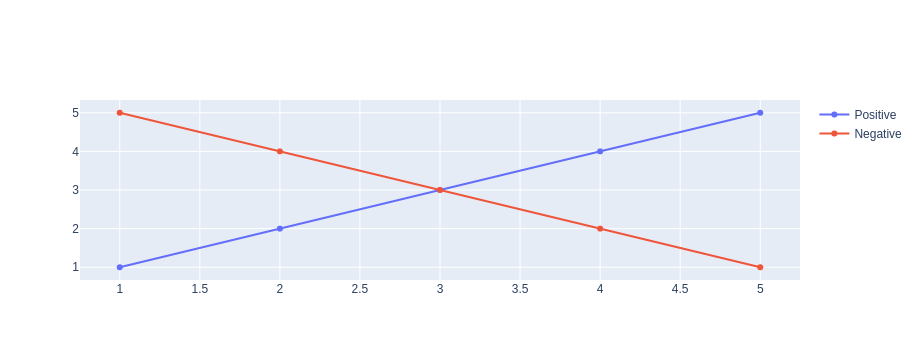

In [55]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5],
    y=[1, 2, 3, 4, 5],
    name="Positive"
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5],
    y=[5, 4, 3, 2, 1],
    name="Negative"
))

fig.show()